In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
import sklearn

In [3]:
pipe_rf = joblib.load("../model/fraud_model_rf.pkl")

In [5]:
df_test_beneficiary = pd.read_csv("../data/Test_Beneficiarydata-1542969243754.csv")
df_test_inpatient = pd.read_csv("../data/Test_Inpatientdata-1542969243754.csv")
df_test_outpatient = pd.read_csv("../data/Test_Outpatientdata-1542969243754.csv")
df_test_provider = pd.read_csv("../data/Test-1542969243754.csv")

In [8]:
print(df_test_beneficiary.isnull().sum())

BeneID                                 0
DOB                                    0
DOD                                63394
Gender                                 0
Race                                   0
RenalDiseaseIndicator                  0
State                                  0
County                                 0
NoOfMonths_PartACov                    0
NoOfMonths_PartBCov                    0
ChronicCond_Alzheimer                  0
ChronicCond_Heartfailure               0
ChronicCond_KidneyDisease              0
ChronicCond_Cancer                     0
ChronicCond_ObstrPulmonary             0
ChronicCond_Depression                 0
ChronicCond_Diabetes                   0
ChronicCond_IschemicHeart              0
ChronicCond_Osteoporasis               0
ChronicCond_rheumatoidarthritis        0
ChronicCond_stroke                     0
IPAnnualReimbursementAmt               0
IPAnnualDeductibleAmt                  0
OPAnnualReimbursementAmt               0
OPAnnualDeductib

In [10]:
print(df_test_inpatient.isnull().sum())

BeneID                       0
ClaimID                      0
ClaimStartDt                 0
ClaimEndDt                   0
Provider                     0
InscClaimAmtReimbursed       0
AttendingPhysician          31
OperatingPhysician        3962
OtherPhysician            8538
AdmissionDt                  0
ClmAdmitDiagnosisCode        0
DeductibleAmtPaid          196
DischargeDt                  0
DiagnosisGroupCode           0
ClmDiagnosisCode_1           0
ClmDiagnosisCode_2          54
ClmDiagnosisCode_3         169
ClmDiagnosisCode_4         404
ClmDiagnosisCode_5         719
ClmDiagnosisCode_6        1197
ClmDiagnosisCode_7        1736
ClmDiagnosisCode_8        2360
ClmDiagnosisCode_9        3238
ClmDiagnosisCode_10       8664
ClmProcedureCode_1        4118
ClmProcedureCode_2        8297
ClmProcedureCode_3        9328
ClmProcedureCode_4        9522
ClmProcedureCode_5        9549
ClmProcedureCode_6        9551
dtype: int64


In [11]:
print(df_test_outpatient.isnull().sum())

BeneID                         0
ClaimID                        0
ClaimStartDt                   0
ClaimEndDt                     0
Provider                       0
InscClaimAmtReimbursed         0
AttendingPhysician           316
OperatingPhysician        104237
OtherPhysician             78222
ClmDiagnosisCode_1          2578
ClmDiagnosisCode_2         47731
ClmDiagnosisCode_3         76575
ClmDiagnosisCode_4         95371
ClmDiagnosisCode_5        107875
ClmDiagnosisCode_6        114035
ClmDiagnosisCode_7        117871
ClmDiagnosisCode_8        120310
ClmDiagnosisCode_9        122278
ClmDiagnosisCode_10       125578
ClmProcedureCode_1        125807
ClmProcedureCode_2        125832
ClmProcedureCode_3        125839
ClmProcedureCode_4        125841
ClmProcedureCode_5        125841
ClmProcedureCode_6        125841
DeductibleAmtPaid              0
ClmAdmitDiagnosisCode     100036
dtype: int64


In [12]:
print(df_test_provider.isnull().sum())

Provider    0
dtype: int64


In [27]:
# df_test_beneficiary['isDead'] = df_test_beneficiary['DOD'].notna().astype(int)
# df_test_beneficiary.drop(columns='DOD', inplace = True)
df_test_beneficiary['Age'] = 2010 - pd.to_datetime(df_test_beneficiary['DOB']).dt.year

# Identify chronic condition columns
chronic_cols = [
    col for col in df_test_beneficiary.columns
    if 'ChronicCond' in col or col == 'RenalDiseaseIndicator'
]

# Convert them to numeric (force non-numeric to NaN, then fill with 0)
df_test_beneficiary[chronic_cols] = df_test_beneficiary[chronic_cols].apply(
    pd.to_numeric, errors='coerce'
).fillna(0)

# Now safely compute ChronicCount
df_test_beneficiary['ChronicCount'] = df_test_beneficiary[chronic_cols].sum(axis=1)


In [14]:
df_test_inpatient['has_attending_physician'] = df_test_inpatient['AttendingPhysician'].notna().astype(int)
df_test_inpatient['has_operating_physician'] = df_test_inpatient['OperatingPhysician'].notna().astype(int)
df_test_inpatient['has_other_physician'] = df_test_inpatient['OtherPhysician'].notna().astype(int)
df_test_inpatient['DeductibleAmtPaid'] = df_test_inpatient['DeductibleAmtPaid'].fillna(0)

In [15]:
diagnosis_cols = [col for col in df_test_inpatient.columns if col.startswith("ClmDiagnosisCode")]

In [16]:
df_test_inpatient['TotalDiagnosisCount'] = df_test_inpatient[diagnosis_cols].notnull().sum(axis=1)
procedure_cols = [col for col in df_test_inpatient.columns if col.startswith('ClmProcedureCode')]
total_procedure_codes = len(procedure_cols)
df_test_inpatient['TotalProcedureCount'] = df_test_inpatient[procedure_cols].notnull().sum(axis=1)
df_test_inpatient['ProcedureDiagnosisRatio'] = df_test_inpatient['TotalProcedureCount'] / (df_test_inpatient['TotalDiagnosisCount']+1)
max_diag = df_test_inpatient['TotalDiagnosisCount'].max()
df_test_inpatient['DiagnosisSlotsFull'] = (df_test_inpatient['TotalDiagnosisCount'] == max_diag).astype(int)

In [28]:
df_test_beneficiary['TotalAnnualReimbursed'] = (df_test_beneficiary['IPAnnualReimbursementAmt'].fillna(0) + 
                                         df_test_beneficiary['OPAnnualReimbursementAmt'].fillna(0))

df_test_beneficiary['TotalAnnualDeductible'] = (df_test_beneficiary['IPAnnualDeductibleAmt'].fillna(0) + 
                                          df_test_beneficiary['OPAnnualDeductibleAmt'].fillna(0))

In [29]:
in_claims = df_test_inpatient[['Provider', 'BeneID']]
out_claims = df_test_outpatient[['Provider', 'BeneID']]

# Combine inpatient + outpatient claims
claims_df = pd.concat([in_claims, out_claims], axis=0)

# Remove duplicates
claims_df = claims_df.drop_duplicates().reset_index(drop=True)

print(claims_df.head())
print("Shape:", claims_df.shape)


provider_bene_map = claims_df[['Provider', 'BeneID']].drop_duplicates()

# Step 3: इस मैप को बेनिफिशियरी डेटा के साथ जोड़ें
provider_bene = provider_bene_map.merge(df_test_beneficiary, on='BeneID', how='left')

   Provider     BeneID
0  PRV57070  BENE11014
1  PRV54750  BENE11017
2  PRV53758  BENE11026
3  PRV55825  BENE11031
4  PRV52338  BENE11085
Shape: (87242, 2)


In [30]:
# STEP 1: make sure df_test_beneficiary has derived columns
df_test_beneficiary['DOB'] = pd.to_datetime(df_test_beneficiary['DOB'], errors='coerce')
df_test_beneficiary['Age'] = 2010 - df_test_beneficiary['DOB'].dt.year

chronic_cols = [
    col for col in df_test_beneficiary.columns
    if 'ChronicCond' in col or col == 'RenalDiseaseIndicator'
]

df_test_beneficiary[chronic_cols] = df_test_beneficiary[chronic_cols].apply(
    pd.to_numeric, errors='coerce'
).fillna(0)

df_test_beneficiary['ChronicCount'] = df_test_beneficiary[chronic_cols].sum(axis=1)

df_test_beneficiary['TotalAnnualReimbursed'] = (
    df_test_beneficiary['IPAnnualReimbursementAmt'].fillna(0) +
    df_test_beneficiary['OPAnnualReimbursementAmt'].fillna(0)
)

df_test_beneficiary['TotalAnnualDeductible'] = (
    df_test_beneficiary['IPAnnualDeductibleAmt'].fillna(0) +
    df_test_beneficiary['OPAnnualDeductibleAmt'].fillna(0)
)

# STEP 2: provider–beneficiary mapping (claims_df MUST exist)
provider_bene_map = claims_df[['Provider', 'BeneID']].drop_duplicates()

# STEP 3: merge beneficiary features INTO provider_bene
provider_bene = provider_bene_map.merge(
    df_test_beneficiary[
        ['BeneID', 'Age', 'ChronicCount',
         'TotalAnnualReimbursed', 'TotalAnnualDeductible']
    ],
    on='BeneID',
    how='left'
)

# STEP 4: now aggregation will work
bene_provider_agg = provider_bene.groupby('Provider').agg(
    Bene_UniqueCount=('BeneID', 'nunique'),
    Bene_AvgAge=('Age', 'mean'),
    Bene_AvgChronicCount=('ChronicCount', 'mean'),
    Bene_PctChronic=('ChronicCount', lambda x: (x > 0).mean()),
    Bene_AvgReimbursed=('TotalAnnualReimbursed', 'mean'),
    Bene_AvgDeductible=('TotalAnnualDeductible', 'mean')
).reset_index()


In [17]:
df_test_inpatient['HighProcedure_95'] = (df_test_inpatient['TotalProcedureCount'] > 2).astype(int)
provider_features = df_test_inpatient.groupby('Provider').agg(
    TotalClaims=('Provider', 'count'),
    AvgDiagnosisCount=('TotalDiagnosisCount', 'mean'),
    AvgProcedureCount=('TotalProcedureCount', 'mean'),
    PctFullDiagnosis=('DiagnosisSlotsFull', 'mean'),
    PctHighProcedure=('HighProcedure_95', 'mean'),
    AvgProcDiagRatio=('ProcedureDiagnosisRatio', 'mean')
).reset_index()
inpatient_provider = provider_features.rename(columns={
    'TotalClaims': 'In_TotalClaims',
    'AvgDiagnosisCount': 'In_AvgDiagnosisCount',
    'AvgProcedureCount': 'In_AvgProcedureCount',
    'PctFullDiagnosis': 'In_PctFullDiagnosis',
    'PctHighProcedure': 'In_PctHighProcedure',
    'AvgProcDiagRatio': 'In_AvgProcDiagRatio'
})


In [20]:
df_test_outpatient['has_attending_physician'] = df_test_outpatient['AttendingPhysician'].notna().astype(int)
df_test_outpatient['has_operating_physician'] = df_test_outpatient['OperatingPhysician'].notna().astype(int)
df_test_outpatient['has_other_physician'] = df_test_outpatient['OtherPhysician'].notna().astype(int)

df_test_outpatient['DeductibleAmtPaid'] = df_test_outpatient['DeductibleAmtPaid'].fillna(0)
diagnosis_cols = [col for col in df_test_outpatient.columns if col.startswith("ClmDiagnosisCode")]
df_test_outpatient['TotalDiagnosisCount'] = df_test_outpatient[diagnosis_cols].notnull().sum(axis=1)

procedure_cols = [col for col in df_test_outpatient.columns if col.startswith('ClmProcedureCode')]
total_procedure_codes = len(procedure_cols)

df_test_outpatient['TotalProcedureCount'] = df_test_outpatient[procedure_cols].notnull().sum(axis=1)
df_test_outpatient['HasProcedure'] = (df_test_outpatient['TotalProcedureCount'] > 0).astype(int)
df_test_outpatient['Out_ProcedureDiagnosisRatio'] = df_test_outpatient['TotalProcedureCount'] / (df_test_outpatient['TotalDiagnosisCount']+1)

max_diag = df_test_outpatient['TotalDiagnosisCount'].max()
df_test_outpatient['DiagnosisSlotsFull'] = (df_test_outpatient['TotalDiagnosisCount'] == max_diag).astype(int)

In [21]:
outpatient_provider = df_test_outpatient.groupby('Provider').agg(
    TotalClaims=('Provider', 'count'),
    AvgDiagnosisCount=('TotalDiagnosisCount', 'mean'),
    AvgProcedureCount=('TotalProcedureCount', 'mean'),
    PctFullDiagnosis=('DiagnosisSlotsFull', 'mean'),
    PctHasProcedure=('HasProcedure', 'mean'),
    AvgProcDiagRatio=('Out_ProcedureDiagnosisRatio', 'mean')
).reset_index()
outpatient_provider = outpatient_provider.rename(columns={
    'TotalClaims': 'Out_TotalClaims',
    'AvgDiagnosisCount': 'Out_AvgDiagnosisCount',
    'AvgProcedureCount': 'Out_AvgProcedureCount',
    'PctFullDiagnosis': 'Out_PctFullDiagnosis',
    'PctHasProcedure': 'Out_PctHasProcedure',
    'AvgProcDiagRatio': 'Out_AvgProcDiagRatio'
})


In [23]:
provider_final = inpatient_provider.merge(
    outpatient_provider,
    on='Provider',
    how='outer'
)
provider_final = provider_final.fillna(0)
provider_final = provider_final.merge(
    df_test_provider[['Provider']],
    on = 'Provider',
    how = 'left'
)

In [25]:
df_test_beneficiary.head()

,BeneID,DOB,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,isDead
0,BENE11001,1943-01-01,1,1,0,39,230,12,12,1,...,1,1,2,1,1,36000,3204,60,70,0
1,BENE11007,1940-09-01,1,2,0,45,610,12,12,1,...,1,2,1,1,2,0,0,1490,160,1
2,BENE11010,1936-07-01,2,1,0,41,30,12,12,2,...,1,1,1,2,2,0,0,1170,660,0
3,BENE11011,1914-03-01,2,2,0,1,360,12,12,2,...,1,2,2,1,1,5000,1068,250,320,0
4,BENE11014,1938-04-01,2,1,Y,45,780,12,12,2,...,2,1,2,2,2,21260,2136,120,100,0


In [31]:
bene_provider_agg = provider_bene.groupby('Provider').agg(
    Bene_UniqueCount=('BeneID', 'nunique'),
    Bene_AvgAge=('Age', 'mean'),
    Bene_AvgChronicCount=('ChronicCount', 'mean'),
    Bene_PctChronic=('ChronicCount', lambda x: (x > 0).mean()),
    Bene_AvgReimbursed=('TotalAnnualReimbursed', 'mean'),
    Bene_AvgDeductible=('TotalAnnualDeductible', 'mean')
).reset_index()

bene_provider_agg.head()


final_df = provider_final.merge(
    bene_provider_agg,
    on='Provider',
    how='left'
)

final_df.fillna(0, inplace=True)


In [32]:
final_df.head()

,Provider,In_TotalClaims,In_AvgDiagnosisCount,In_AvgProcedureCount,In_PctFullDiagnosis,In_PctHighProcedure,In_AvgProcDiagRatio,Out_TotalClaims,Out_AvgDiagnosisCount,Out_AvgProcedureCount,Out_PctFullDiagnosis,Out_PctHasProcedure,Out_AvgProcDiagRatio,Bene_UniqueCount,Bene_AvgAge,Bene_AvgChronicCount,Bene_PctChronic,Bene_AvgReimbursed,Bene_AvgDeductible
0,PRV51002,0.0,0.0,0.0,0.0,0.0,0.000000,205.0,2.663415,0.0,0.000000,0.0,0.0,169,73.053254,17.875740,1.0,6784.319527,1114.189349
1,PRV51006,0.0,0.0,0.0,0.0,0.0,0.000000,102.0,2.823529,0.0,0.009804,0.0,0.0,81,75.074074,17.765432,1.0,6109.506173,1130.320988
2,PRV51009,2.0,7.5,1.5,0.5,0.0,0.212121,37.0,2.837838,0.0,0.000000,0.0,0.0,30,69.533333,18.200000,1.0,6890.666667,1049.733333
3,PRV51010,6.0,7.0,0.5,0.0,0.0,0.061111,32.0,2.375000,0.0,0.031250,0.0,0.0,25,73.480000,17.560000,1.0,6170.000000,1017.280000
4,PRV51018,0.0,0.0,0.0,0.0,0.0,0.000000,190.0,2.694737,0.0,0.000000,0.0,0.0,146,73.239726,17.698630,1.0,6242.260274,1099.232877


In [36]:
final_df.shape

(1353, 19)

In [37]:
final_df.columns

Index(['Provider', 'In_TotalClaims', 'In_AvgDiagnosisCount',
       'In_AvgProcedureCount', 'In_PctFullDiagnosis', 'In_PctHighProcedure',
       'In_AvgProcDiagRatio', 'Out_TotalClaims', 'Out_AvgDiagnosisCount',
       'Out_AvgProcedureCount', 'Out_PctFullDiagnosis', 'Out_PctHasProcedure',
       'Out_AvgProcDiagRatio', 'Bene_UniqueCount', 'Bene_AvgAge',
       'Bene_AvgChronicCount', 'Bene_PctChronic', 'Bene_AvgReimbursed',
       'Bene_AvgDeductible'],
      dtype='object')

In [49]:
final_df.to_csv("final_testing_data.csv")

In [38]:
X_test_final = final_df.drop(columns=['Provider'], errors='ignore')

In [39]:
threshold = 0.4 
y_test_prob = pipe_rf.predict_proba(X_test_final)[:, 1]
y_test_pred = (y_test_prob >= threshold).astype(int)


In [40]:
y_test_prob

array([0.10721504, 0.12826132, 0.14827168, ..., 0.02169562, 0.07990911,
       0.12084522])

In [41]:
y_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [44]:
submission = final_df[['Provider']].copy()
submission['Fraud_Probability'] = y_test_prob
submission['Fraud_Flag'] = y_test_pred
submission['PotentialFraud'] = submission['Fraud_Flag'].map({0: 'No', 1: 'Yes'})
submission.to_csv("fraud_predictions_final.csv", index=False)



In [45]:
test_result = pd.read_csv("../testing_notebook/fraud_predictions_final.csv")
test_result.head()

,Provider,Fraud_Probability,Fraud_Flag,PotentialFraud
0,PRV51002,0.107215,0,No
1,PRV51006,0.128261,0,No
2,PRV51009,0.148272,0,No
3,PRV51010,0.131720,0,No
4,PRV51018,0.108314,0,No


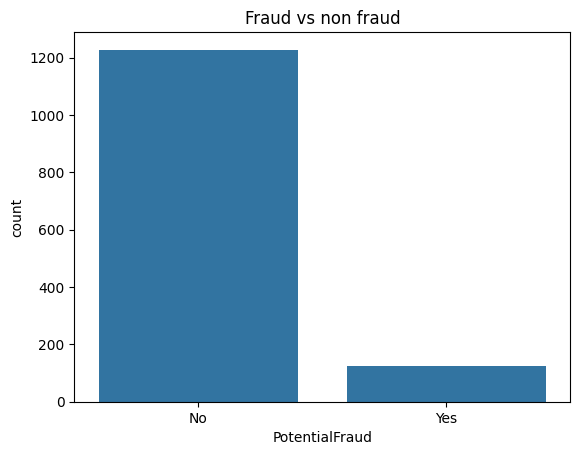

In [48]:
sns.countplot(x = 'PotentialFraud', data = test_result)
plt.title("Fraud vs non fraud")
plt.show()